## Predicting next lab results

#### 배경
- 환자의 근미래의 검사 결과를 맞출 수 있을까?

#### 문제 종류
- Univariate Time series prediction  
//- binary classification (검사 결과가 정상범위인지 아닌지)

#### 실험
- 환자의 관찰값을 기반으로 다음 관찰값을 예상하기.

#### 교차검증

#### 평가

#### 예측값의 활용
- 수련의 교육용

# MLP for time series

### univariate
Ref : https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/

In [1]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
import sys
sys.path.insert(0, '../db')
import db_con
import sqlalchemy

#### Toy Example

In [3]:
# dataset
X = array([[10, 20, 30], [20, 30, 40], [30, 40, 50], [40, 50, 60]])
y = array([40, 50, 60, 70])

In [4]:
model = Sequential()
#모델은 입력값에 대한 정의가 필요하기 대문에, 순차 모델의 첫번째 레이어는 사용자로부터 어떤 입력이 주어질지 정보를 제공해야한다.
model.add(Dense(100, activation='relu', input_dim=3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
model.fit(X, y, epochs=2000, verbose=0)

Instructions for updating:
Use tf.cast instead.


In [6]:
x_input = array([50, 60, 70])
x_input = x_input.reshape((1, 3))
x_input

array([[50, 60, 70]])

In [7]:
y_exp = model.predict(x_input, verbose=0)
y_exp

array([[80.15991]], dtype=float32)

### Respiratory Rate

In [8]:
#### Sepsis 환자(25030)의 ICU 기록 중 하나를 선택(276176)

In [9]:
# load chartevents
# chartevents contain variables such as heart rate, respiratory rate, temperature
engine = db_con.get_engine()
pat = pd.read_sql("""
                    SELECT de.icustay_id, de.mins, de.value, de.valuenum, de.itemid, di.label
                    FROM (SELECT
                            de.icustay_id,
                            EXTRACT(MINUTE FROM de.charttime - (SELECT intime
                                                              FROM icustays
                                                              WHERE icustay_id = 256064)) AS mins,
                            de.value,
                            de.valuenum,
                            de.itemid
                          FROM chartevents de
                          WHERE icustay_id = 256064) AS de
                      INNER JOIN (SELECT
                                    di.label,
                                    di.itemid
                                  FROM d_items di) AS di
                        ON de.itemid = di.itemid
                    ORDER BY mins;
                    """, engine)

In [10]:
pat.head()

,icustay_id,mins,value,valuenum,itemid,label
0,256064,0.0,69,69.0,220045,Heart Rate
1,256064,0.0,120,120.0,220046,Heart rate Alarm - High
2,256064,0.0,50,50.0,220047,Heart Rate Alarm - Low
3,256064,0.0,90,90.0,220056,Arterial Blood Pressure Alarm - Low
4,256064,0.0,190,190.0,220058,Arterial Blood Pressure Alarm - High


Number of breaths you take per minute. The normal respiration rate for an adult at rest is 12 to 20 breaths per minute. A respiration rate under 12 or over 25 breaths per minute while resting is considered abnormal.  
Ref - https://my.clevelandclinic.org/health/articles/10881-vital-signs

Text(0.5, 1.0, 'Respiratory Rate change over time from admission to icu')

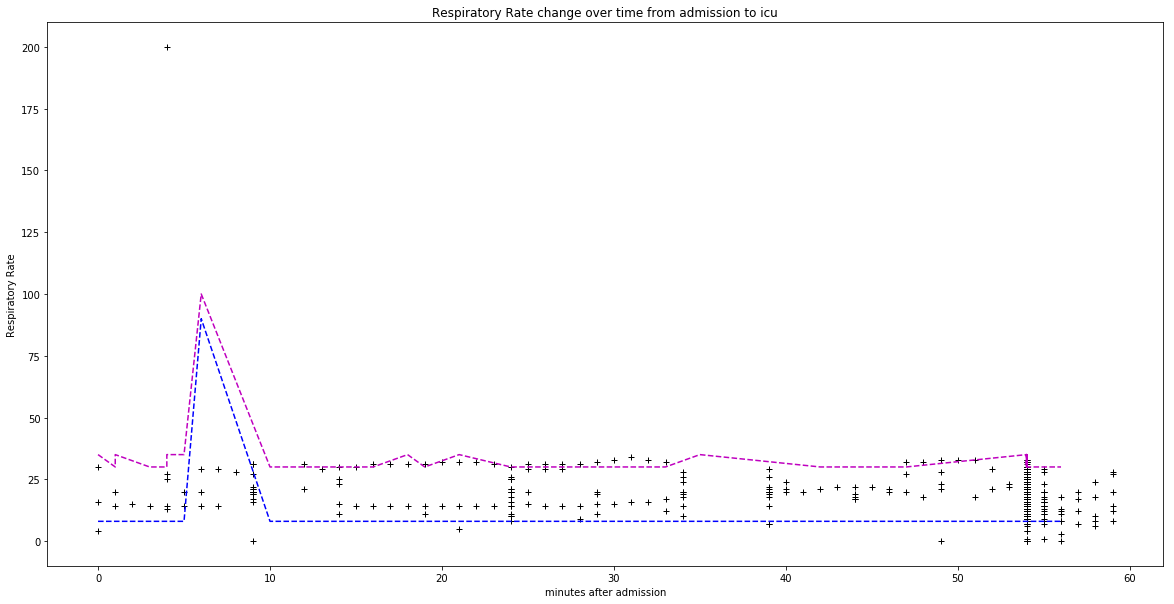

In [11]:
plt.figure(figsize=(20, 10))

plt.plot(pat.mins[pat.label=='Respiratory Rate'],
        pat.valuenum[pat.label=='Respiratory Rate'],
        'k+')

plt.plot(pat.mins[pat.label=='Resp Alarm - High'],
        pat.valuenum[pat.label=='Resp Alarm - High'],
        'm--')

plt.plot(pat.mins[pat.label=='Resp Alarm - Low'],
        pat.valuenum[pat.label=='Resp Alarm - Low'],
        'b--')

plt.xlabel('minutes after admission')
plt.ylabel('Respiratory Rate')
plt.title('Respiratory Rate change over time from admission to icu')

In [12]:
pat_resp = pat[pat.label=='Respiratory Rate']
pat_resp.head()

,icustay_id,mins,value,valuenum,itemid,label
23,256064,0.0,4,4.0,220210,Respiratory Rate
54,256064,0.0,16,16.0,220210,Respiratory Rate
89,256064,0.0,30,30.0,220210,Respiratory Rate
242,256064,1.0,20,20.0,220210,Respiratory Rate
265,256064,1.0,14,14.0,220210,Respiratory Rate


In [13]:
pat_resp.loc[pat_resp.valuenum>50]

,icustay_id,mins,value,valuenum,itemid,label
1018,256064,4.0,200,200.0,220210,Respiratory Rate


In [14]:
pat_resp.loc[pat_resp.mins==4.0]

,icustay_id,mins,value,valuenum,itemid,label
835,256064,4.0,27,27.0,220210,Respiratory Rate
867,256064,4.0,25,25.0,220210,Respiratory Rate
984,256064,4.0,13,13.0,220210,Respiratory Rate
1017,256064,4.0,14,14.0,220210,Respiratory Rate
1018,256064,4.0,200,200.0,220210,Respiratory Rate


In [15]:
print(pat_resp.shape)

# abnormal value 200 should be removed
pat_resp = pat_resp.loc[pat_resp.valuenum<100]

print(pat_resp.shape)

(713, 6)
(712, 6)


In [16]:
pat_resp.mins.max()

59.0

In [17]:
resp_index = [x for x in range(int(pat_resp.mins.max())+1)]
# resp_index

In [18]:
# choose to take only max value for observations within a minute
max_by_min = pat_resp.groupby(['mins'], sort=True)['valuenum'].max()
max_by_min = max_by_min.reindex(resp_index)

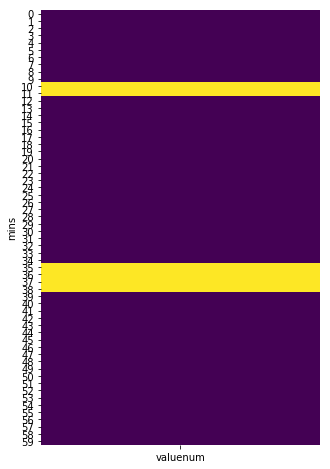

In [19]:
# missing data visualization with heatmap
import seaborn as sns

plt.figure(figsize=(5, 8))

sns.heatmap(max_by_min.isnull().to_frame(), yticklabels=True, cbar=False, cmap='viridis')

In [20]:
# missing value 채우기
max_by_min = max_by_min.fillna(method='ffill')
# max_by_min

Text(0.5, 1.0, 'Respiratory Rate change over time from admission to icu')

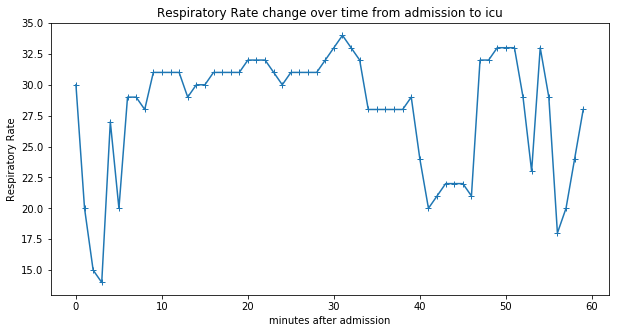

In [21]:
plt.figure(figsize=(10, 5))

plt.plot(max_by_min.index,
        max_by_min,
        '+-')

plt.xlabel('minutes after admission')
plt.ylabel('Respiratory Rate')
plt.title('Respiratory Rate change over time from admission to icu')

In [22]:
resp_X = []
resp_y = []
resp_X_test = []
resp_y_test = []
train = max_by_min[:50]
test = max_by_min[46:].to_list()

In [23]:
for i in range(train.shape[0]-4):
#     print(max_by_min[i])
    resp_X.append(train[i:i+4])
    resp_y.append(train[i+4])
    
for i in range(len(test)-4):
    resp_X_test.append(test[i : i+4])
    resp_y_test.append(test[i+4])

In [24]:
resp_X = array(resp_X)
resp_y = array(resp_y)
len(resp_X)
len(resp_y)

46

In [25]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=4))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               500       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________


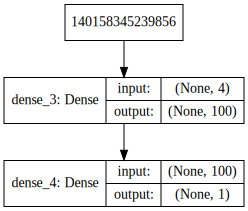

In [27]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [28]:
model.fit(resp_X, resp_y, epochs=2000, verbose=0)

In [29]:
array(resp_X_test[0]).reshape(1, 4)

array([[21., 32., 32., 33.]])

In [30]:
y_exps = []
for resp_test in resp_X_test:    
    y_exps.append(model.predict(array(resp_test).reshape(1, 4), verbose=0)[0][0])

In [31]:
y_exps

[35.778942,
 32.577,
 32.447414,
 28.85563,
 24.182055,
 29.64857,
 30.302855,
 20.642115,
 28.38751,
 21.65576]

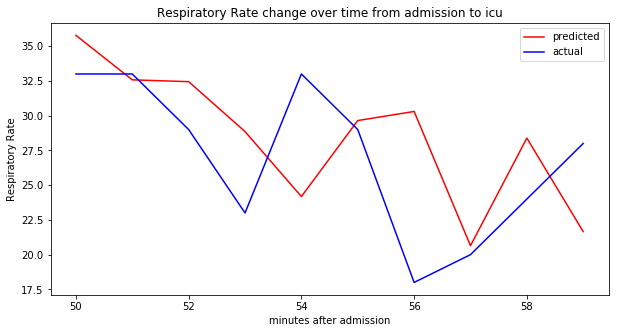

In [32]:
plt.figure(figsize=(10, 5))

plt.plot([x for x in range(50,60)],
        y_exps,
        'r-',
        label='predicted')

plt.plot([x for x in range(50,60)],
        resp_y_test,
        'b-',
        label='actual')

plt.xlabel('minutes after admission')
plt.ylabel('Respiratory Rate')
plt.title('Respiratory Rate change over time from admission to icu')
plt.legend(loc='upper right')

# CNN for time series
- 좋은 예제는 아닌듯해서 제외해도 좋을 듯

In [33]:
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [34]:
#reshape dataset from [samples, timesteps] into [samples, timesteps, features]
#in this case we will just put features as 1
resp_X = resp_X.reshape((resp_X.shape[0], resp_X.shape[1], 1))

In [35]:
model = Sequential()
model.add(Conv1D(filters=60, kernel_size=2, activation='relu', input_shape=(4, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

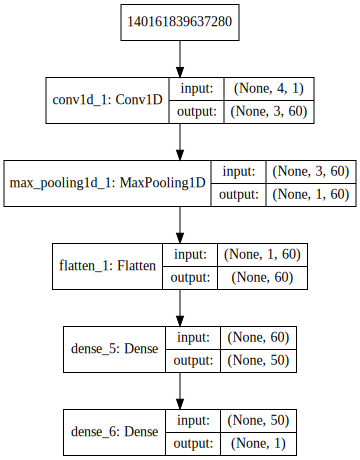

In [36]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [37]:
model.fit(resp_X, resp_y, epochs=1000, verbose=0)

In [38]:
# resp_X.reshape((resp_X.shape[0], resp_X.shape[1], 1))
array(resp_X_test[0]).reshape(1, 4, 1)

array([[[21.],
        [32.],
        [32.],
        [33.]]])

In [39]:
y_exps = []
for resp_test in resp_X_test:    
    y_exps.append(model.predict(array(resp_test).reshape(1, 4, 1), verbose=0)[0][0])

In [40]:
y_exps

[35.284893,
 32.031322,
 32.39615,
 32.017666,
 32.16729,
 29.159937,
 33.043686,
 34.90885,
 29.217104,
 24.19642]

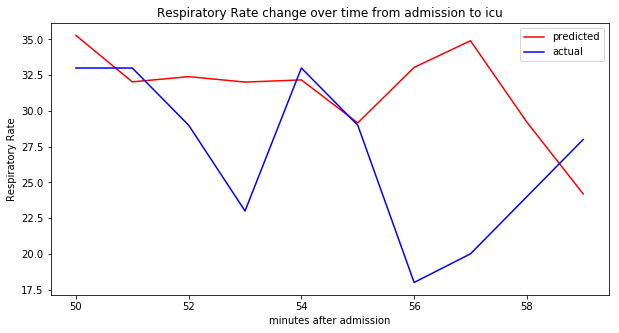

In [41]:
plt.figure(figsize=(10, 5))

plt.plot([x for x in range(50,60)],
        y_exps,
        'r-',
        label='predicted')

plt.plot([x for x in range(50,60)],
        resp_y_test,
        'b-',
        label='actual')

plt.xlabel('minutes after admission')
plt.ylabel('Respiratory Rate')
plt.title('Respiratory Rate change over time from admission to icu')
plt.legend(loc='upper right')

# LSTM for time series

In [42]:
from keras.layers import LSTM

In [43]:
model = Sequential()
#input_shape(n_steps, n_features) -> univariate model so the number of features is one.
model.add(LSTM(50, activation='relu', input_shape=(4, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

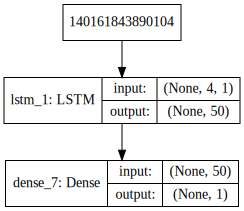

In [44]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [45]:
model.fit(resp_X, resp_y, epochs=1000, verbose=0)

In [46]:
y_exps = []
for resp_test in resp_X_test:    
    #[samples, timesteps, features] n_feature = 1
    y_exps.append(model.predict(array(resp_test).reshape(1, 4, 1), verbose=0)[0][0])

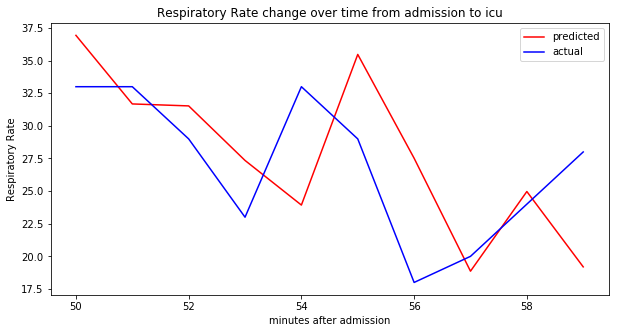

In [47]:
plt.figure(figsize=(10, 5))

plt.plot([x for x in range(50,60)],
        y_exps,
        'r-',
        label='predicted')

plt.plot([x for x in range(50,60)],
        resp_y_test,
        'b-',
        label='actual')

plt.xlabel('minutes after admission')
plt.ylabel('Respiratory Rate')
plt.title('Respiratory Rate change over time from admission to icu')
plt.legend(loc='upper right')